출처: https://wikidocs.net/72820
# 아마존 리뷰 데이터

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

# 1) 데이터 로드하기

In [18]:
# 데이터 로드하기
data = pd.read_csv("/content/Reviews.csv", nrows = 10000)
print('전체 리뷰 개수 :', (len(data)))

전체 리뷰 개수 : 10000


In [19]:
data.head()

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]

# 2) 데이터 전처리

In [20]:
# 필요한 열만 저장
data = data[['Text', 'Summary']]
data.head()

Text                Summary
0  I have bought several of the Vitality canned d...  Good Quality Dog Food
1  Product arrived labeled as Jumbo Salted Peanut...      Not as Advertised
2  This is a confection that has been around a fe...  "Delight" says it all
3  If you are looking for the secret ingredient i...         Cough Medicine
4  Great taffy at a great price.  There was a wid...            Great taffy

In [21]:
# 데이터 정제
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 9513
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 8526


In [22]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 9513


In [23]:
# Null 데이터 있는지 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [24]:
# 단어 정규화 (동일의미지만 스펠링이 다른 단어)

# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
                "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is",
                "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
                "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", 
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [27]:
# NLTK의 불용어
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
불용어 개수 : 179
{'while', 'was', 'between', 'too', 'into', 'can', 'some', 'so', 'against', 'at', 'weren', 'no', 'being', 'our', 'there', 'or', 'm', 'be', "you'll", 'by', 'theirs', 'were', 'don', 'and', "shan't", 'out', 'that', 'in', 'her', 'a', 'doesn', 'where', "won't", 'your', 'those', 'after', 'down', 'to', 'if', "weren't", "don't", 'me', 'we', 'my', 'the', 'his', 'these', 'until', "she's", "aren't", 're', 'ma', 'it', 'very', 'mightn', 'hadn', 'needn', 'shouldn', 'did', 'couldn', 'over', 'has', 'myself', 'them', 'off', 'will', 'when', 'ourselves', 'of', 'each', 'him', 'doing', 'up', 'what', "you'd", 'ours', 'few', 'only', 'o', "wouldn't", "wasn't", "didn't", 'then', 'aren', "that'll", 'about', 's', 'hers', 'their', "haven't", 'themselves', 'all', 'such', 'ain', 'mustn', 'any', 'haven', "it's", 't', 've', 'because', "hadn't", 'this', 'she', 'through', 'above', "needn't", 'herse

In [28]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [29]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [30]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [31]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [32]:
# 전처리 후의 결과를 데이터프레임에 다시 저장
data['Text'] = clean_text
data['Summary'] = clean_summary

In [33]:
# 전처리 과정에서 빈 값이 생겼다면 Null값으로 변경한 후에 Null값을 가진 샘플이 생겼는지 확인.
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text       0
Summary    8
dtype: int64


In [34]:
# Null값인 샘플들 제거
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 9505


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 845
텍스트의 평균 길이 : 36.62219884271436
요약의 최소 길이 : 1
요약의 최대 길이 : 25
요약의 평균 길이 : 3.938453445554971


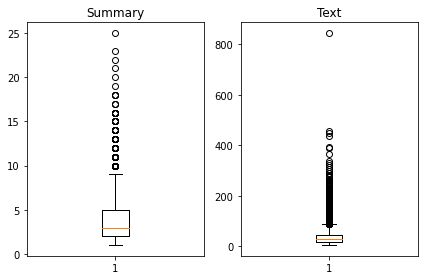

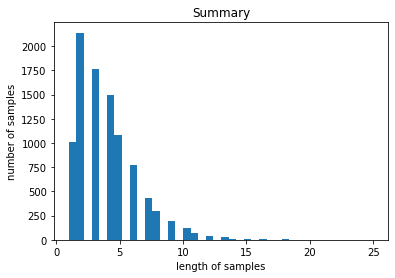

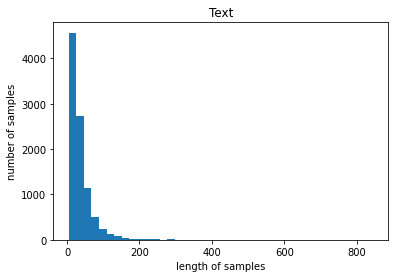

In [35]:
# Text, Summary열의 길이 확인
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 원문 텍스트는 대체적으로 100이하의 길이.
# 평균 길이를 통해 패딩 길이 설정. -> 넉넉히 text는 50, summary는 8.

In [36]:
text_max_len = 50
summary_max_len = 8

In [37]:
# 전체 샘플들 선정 길이 비율 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [38]:
print(below_threshold_len(text_max_len, data['Text']))
print(below_threshold_len(summary_max_len, data['Summary']))

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7974750131509731
None
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9465544450289322
None


In [39]:
# 정해준 최대 길이보다 큰 샘플 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 7309


In [40]:
# 정해준 최대 길이보다 큰 샘플들 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 7309


In [42]:
data.head()

Text                Summary
0  bought several vitality canned dog food produc...  good quality dog food
1  product arrived labeled jumbo salted peanuts p...      not as advertised
2  confection around centuries light pillowy citr...    delight says it all
3  looking secret ingredient robitussin believe f...         cough medicine
4  great taffy great price wide assortment yummy ...            great taffy

In [43]:
# seq2seq 훈련 위해서는 디코더 입력과 레이블에 시작 토큰과 종료 토큰 추가 필요.
# 시작 토큰: sostoken, 종료 토큰: eostoken

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

Text  ...                  decoder_target
0  bought several vitality canned dog food produc...  ...  good quality dog food eostoken
1  product arrived labeled jumbo salted peanuts p...  ...      not as advertised eostoken
2  confection around centuries light pillowy citr...  ...    delight says it all eostoken
3  looking secret ingredient robitussin believe f...  ...         cough medicine eostoken
4  great taffy great price wide assortment yummy ...  ...            great taffy eostoken

[5 rows x 4 columns]

In [44]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 저장
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 3) 데이터셋 분리

In [46]:
# 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[6060 1921 6665 ... 1653 2607 2732]


In [47]:
# 데이터 샘플 순서 바꾸기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [48]:
# 8:2 비율로 나누기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 1461


In [49]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [50]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 5848
훈련 레이블의 개수 : 5848
테스트 데이터의 개수 : 1461
테스트 레이블의 개수 : 1461


# 4) 정수 인코딩

In [51]:
# 단어 집합 생성 + 각 단어에 고유한 정수 부
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [52]:
# 빈도수가 낮은 단어들은 배제.
# 빈도수가 7회 미만인 단어들이 이 데이터에서의 비중 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10844
등장 빈도가 6번 이하인 희귀 단어의 수: 8392
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2452
단어 집합에서 희귀 단어의 비율: 77.38841755809665
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.33577593343075


In [53]:
# 등장 빈도가 적은 단어는제거
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [54]:
# 샘플 3개 출력
print(encoder_input_train[:3])

[[514, 8, 6, 171, 28, 592, 11, 1366, 21, 179, 86, 76], [462, 901, 2453, 1003, 869, 5844, 309, 369, 3, 332, 116, 94, 22], [305, 274, 197, 1143, 4391, 1251, 134, 354, 1252, 614, 82, 5845]]


In [55]:
# 레이블에 해당되는 요약 데이터에서도 똑같이 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3051
등장 빈도가 5번 이하인 희귀 단어의 수: 2553
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 498
단어 집합에서 희귀 단어의 비율: 83.67748279252703
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.569505849211627


In [56]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 43, 584], [1, 6, 10], [1, 191, 1426, 22, 949], [1, 585, 42], [1, 7, 433]]
[[43, 584, 2], [6, 10, 2], [191, 1426, 22, 949, 2], [585, 42, 2], [7, 433, 2]]


# 5) 빈 샘플 제거

In [57]:
# 빈도수가 낮은 단어는 삭제되어서, 빈도수가 낮은 단어만으로 구성된 샘플들은 빈 샘플이 됨.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 72
삭제할 테스트 데이터의 개수 : 50


In [58]:
# 삭제 후의 개수
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 5776
훈련 레이블의 개수 : 5776
테스트 데이터의 개수 : 1411
테스트 레이블의 개수 : 1411


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 6) 패딩하기

In [59]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 7) seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [60]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 인코더 설계

In [62]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 디코더 설계
 - 출력층 제외
 - 인코더와 비슷하지만, 초기 상태를 인코더의 상태로 하기


In [63]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [64]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [65]:
# 위 출력층 말고 어텐션 메커니즘이 결합된 새로운 출력층으로 설계하기
# AttentionLayer 임포하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [66]:
# 어텐션 메커니즘을 이용해 디코더의 출력층 새롭게 생성

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [67]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [68]:
# 조기종료 조건 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
23/23 [==============================] - 135s 5s/step - loss: 3.6670 - val_loss: 2.7958
Epoch 2/50
23/23 [==============================] - 116s 5s/step - loss: 2.9295 - val_loss: 2.5649
Epoch 3/50
23/23 [==============================] - 117s 5s/step - loss: 2.7221 - val_loss: 2.4515
Epoch 4/50
23/23 [==============================] - 118s 5s/step - loss: 2.6360 - val_loss: 2.4048
Epoch 5/50
23/23 [==============================] - 117s 5s/step - loss: 2.5722 - val_loss: 2.3873
Epoch 6/50
23/23 [==============================] - 121s 5s/step - loss: 2.5199 - val_loss: 2.3498
Epoch 7/50
23/23 [==============================] - 118s 5s/step - loss: 2.4715 - val_loss: 2.3630
Epoch 8/50
23/23 [==============================] - 120s 5s/step - loss: 2.4391 - val_loss: 2.3447
Epoch 9/50
23/23 [==============================] - 118s 5s/step - loss: 2.4147 - val_loss: 2.3583
Epoch 10/50
23/23 [==============================] - 118s 5s/step - loss: 2.3911 - val_loss: 2.3476
Epoch 000

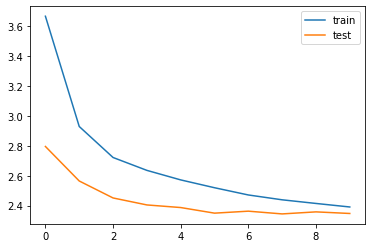

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 8) seq2seq + attention으로 요약 모델 테스트하기

In [70]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계

In [71]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [72]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [73]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [74]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [75]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [76]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  happy discovered product tried several brands extract powder form nunaturals far best virtually aftertaste quick dissolving convenient also economical cents serving use teaspoon measuring spoon sweetens coffee tea perfectly flavor get stevia powder happy 
실제 요약문 : the best have ever had 
예측 요약문 :  great


원문 :  post nasal drip congestion many years tea made big difference couple days drink times per day feel much better breathe easier little post nasal drip throughout day 
실제 요약문 : this tea works feel so much better 
예측 요약문 :  great


원문 :  hot coca tastes pretty good brewed oz setting however best ever tasted worst hard rate everyone different tastes like self happen like buy unless find something better 
실제 요약문 : tastes pretty good 
예측 요약문 :  great


원문 :  buy ship save program staple breakfast snack routine light flavorful full vitamins take minutes bake minimal vegan use egg substitutes still bake perfectly 
실제 요약문 : delicious packed fast 
예측 요약문 :  great


원문 :  herb savor w